In [1]:
import numpy as np
from matplotlib import pyplot as plt

from data_generation import tbp_energy_calculations, Three_body_2D_Rick
from data_generation import tbp_util

In [11]:
# todo read from config file
G = 1.0
M = np.array([1.0, 1.0, 1.0])

In [12]:
def visualize_dataset(x, y, vx, vy, down_sample_factor=100):
    # down sample using slicing [start:stop:step]
    x = x[::down_sample_factor]
    y = y[::down_sample_factor]
    vx = vx[::down_sample_factor]
    vy = vy[::down_sample_factor]

    energy = np.ndarray(dtype=float, shape=(x.shape[0], 3))
    for i in range(energy.shape[0]):
        locations = np.array([x[i], y[i]]).T
        velocities = np.array([vx[i], vy[i]]).T

        potential_energy, kinetic_energy, system_energy = \
            tbp_energy_calculations.energy_values(G, M, locations, velocities)
        energy[i,] = [potential_energy, kinetic_energy, system_energy]
    # energy = pd.DataFrame(energy, columns = ["potential_energy", "kinetic_energy", "system_energy"])
    plt.figure()
    plt.violinplot(energy)
    plt.boxplot(energy)
    plt.show()

    plt.figure()
    plt.plot(energy.T[0])
    plt.plot(energy.T[1])
    plt.plot(energy.T[2])
    plt.legend(["potential_energy", "kinetic_energy", "system_energy"])
    plt.show()

    Three_body_2D_Rick.plot(x, y)


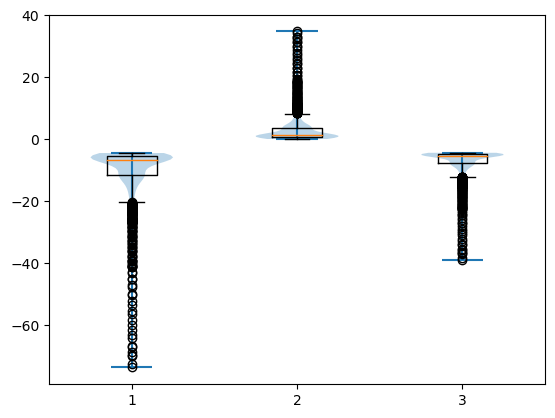

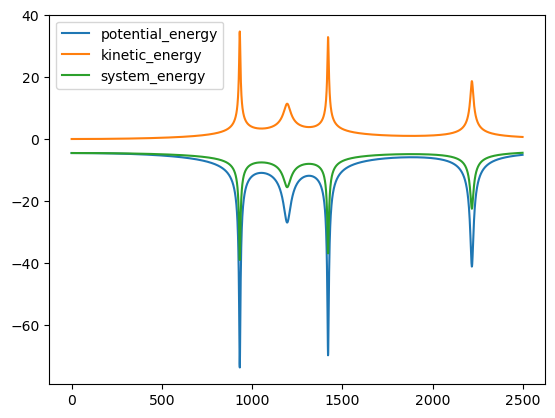

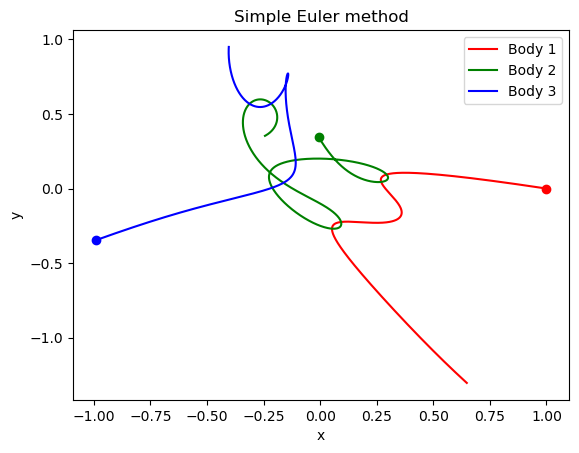

In [13]:
# for dataset, x, y, vx, vy in load_datasets(load_successful=False, load_unsuccessful=True, limit=100):
#     visualize_dataset(x, y, vx, vy)

visualize_dataset(*tbp_util.load_dataset("4"))

In [14]:
from tensorflow import keras

keras.backend.set_floatx('float64')
keras.backend.floatx()

2023-06-06 20:02:59.510443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'float64'

In [15]:
model = keras.Sequential([
    keras.layers.Dense(64, activation=keras.activations.relu, input_shape=[12]),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dense(12, activation=keras.activations.linear)
])
model.compile(
    keras.optimizers.Adam(),
    loss='mae',
    metrics=['mae', 'mse']
)

2023-06-06 20:03:04.314984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
x_train = np.ndarray((0, 12), dtype=np.float64)
y_train = np.ndarray((0, 12), dtype=np.float64)

for dataset, x, y, vx, vy in tbp_util.load_datasets(limit=5):
    input_data = np.column_stack((x, y, vx, vy))
    output_data = input_data.copy()

    input_data = input_data[:-100, ]  # delete last 100
    output_data = output_data[100:, ]  # delete first 100

    x_train = np.concatenate((x_train, input_data))
    y_train = np.concatenate((y_train, output_data))


In [27]:
history = model.fit(
    x_train, y_train,
    batch_size=1028,
    epochs=256,
    validation_split=0.1
)

Epoch 1/256
1094/1094 [==============================] - 7s 6ms/step - loss: 0.0352 - mae: 0.0352 - mse: 0.0191 - val_loss: 0.3227 - val_mae: 0.3227 - val_mse: 0.2011
Epoch 2/256
1094/1094 [==============================] - 6s 6ms/step - loss: 0.0108 - mae: 0.0108 - mse: 0.0019 - val_loss: 0.3162 - val_mae: 0.3162 - val_mse: 0.1897
Epoch 3/256
1094/1094 [==============================] - 6s 6ms/step - loss: 0.0095 - mae: 0.0095 - mse: 0.0013 - val_loss: 0.3218 - val_mae: 0.3218 - val_mse: 0.1899
Epoch 4/256
1094/1094 [==============================] - 6s 6ms/step - loss: 0.0086 - mae: 0.0086 - mse: 0.0010 - val_loss: 0.3193 - val_mae: 0.3193 - val_mse: 0.1854
Epoch 5/256
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0079 - mae: 0.0079 - mse: 8.3105e-04 - val_loss: 0.3205 - val_mae: 0.3205 - val_mse: 0.1859
Epoch 6/256
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0076 - mae: 0.0076 - mse: 6.9904e-04 - val_loss: 0.3213 - val_mae: 0.3213 - val_ms

In [28]:
import math

y_pred = np.zeros(x_train.shape, dtype=np.float64)
y_pred[0,] = x_train[0,]

limit = y_pred.shape[0]
# limit = math.floor(limit / 2.5)
limit = math.floor(limit / 100)

y_pred = y_pred[:int(limit), ]
for i in range(limit - 1):
    prediction = model(y_pred[i,].reshape(1, 12), training=False).numpy()
    y_pred[i + 1,] = prediction

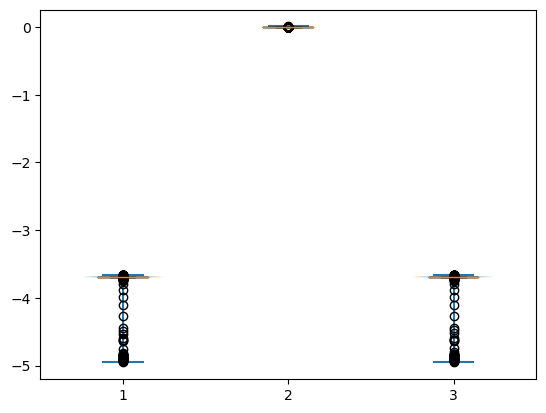

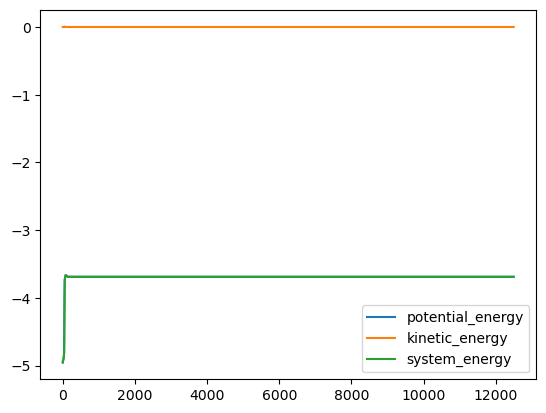

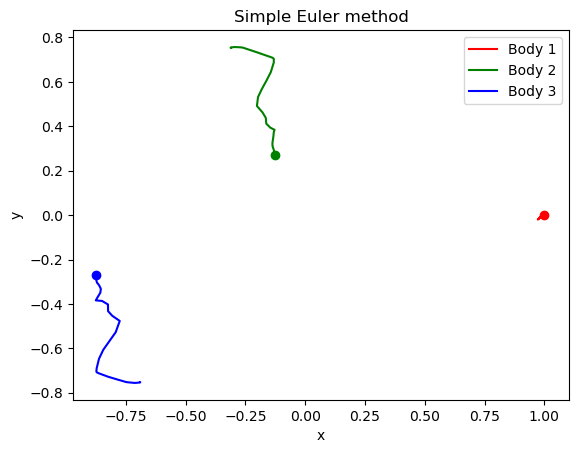

In [29]:
x, y, vx, vy = np.hsplit(y_pred, 4)
# x, y, vx, vy = np.hsplit(x_train[:25000], 4)
visualize_dataset(x, y, vx, vy, down_sample_factor=1)

In [113]:
print(x[:, 0])

[1.         1.00016189 1.00029433 ... 1.00031149 1.00031161 1.00031161]
